In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e1/sample_submission.csv
/kaggle/input/playground-series-s5e1/train.csv
/kaggle/input/playground-series-s5e1/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense, GRU, Input
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# **1- Data Analysis & Handling Missing values**

In [3]:
df_train = pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


In [4]:
missing_values_count = df_train.isnull().sum()
missing_values_count

id             0
date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64

In [5]:
df_train.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [6]:
def plot_data(name, data):
    plt.figure(figsize=(5, 5))
    palette_color = sns.color_palette('pastel')
    explode = [0.1 for _ in range(data.nunique())]

    target_counts = df_train.groupby(name)[name].count()

    target_counts.plot.pie(
    colors=palette_color,
    explode=explode,
    autopct="%1.1f%%",
    shadow=True,
    startangle=140,
    textprops={'fontsize': 14},
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5} 
    )

    plt.title(name, fontsize=18, weight='bold')
    plt.axis('equal')
    plt.show()

In [7]:
print('country :',df_train['country'].unique())
print('store :',df_train['store'].unique())
print('product :',df_train['product'].unique())

country : ['Canada' 'Finland' 'Italy' 'Kenya' 'Norway' 'Singapore']
store : ['Discount Stickers' 'Stickers for Less' 'Premium Sticker Mart']
product : ['Holographic Goose' 'Kaggle' 'Kaggle Tiers' 'Kerneler'
 'Kerneler Dark Mode']


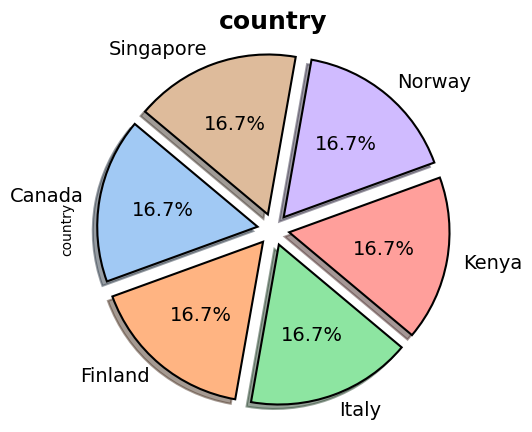

In [8]:
plot_data('country', df_train['country'])

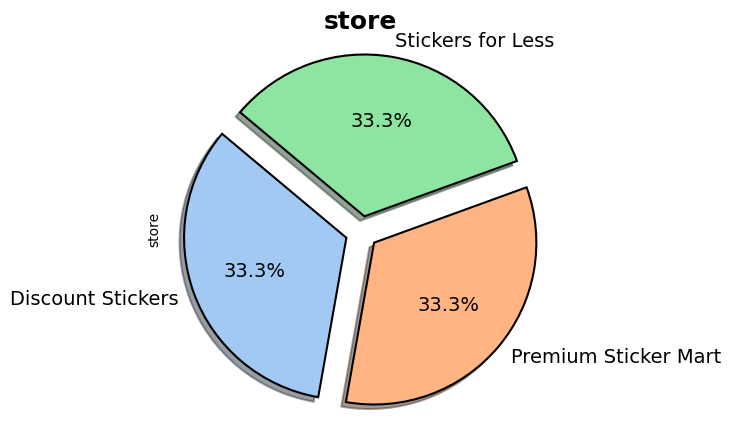

In [9]:
plot_data('store', df_train['store'])

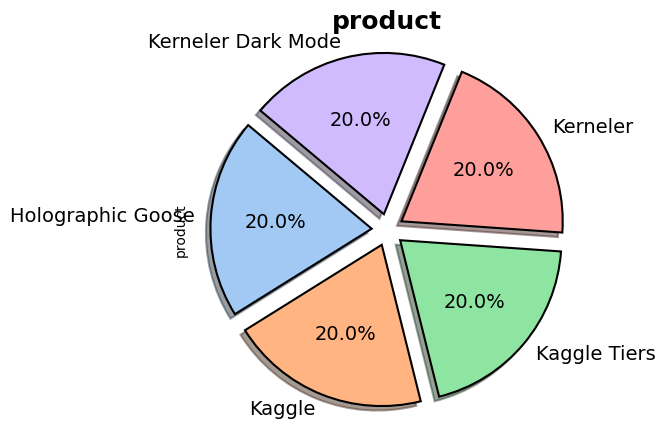

In [10]:
plot_data('product', df_train['product'])

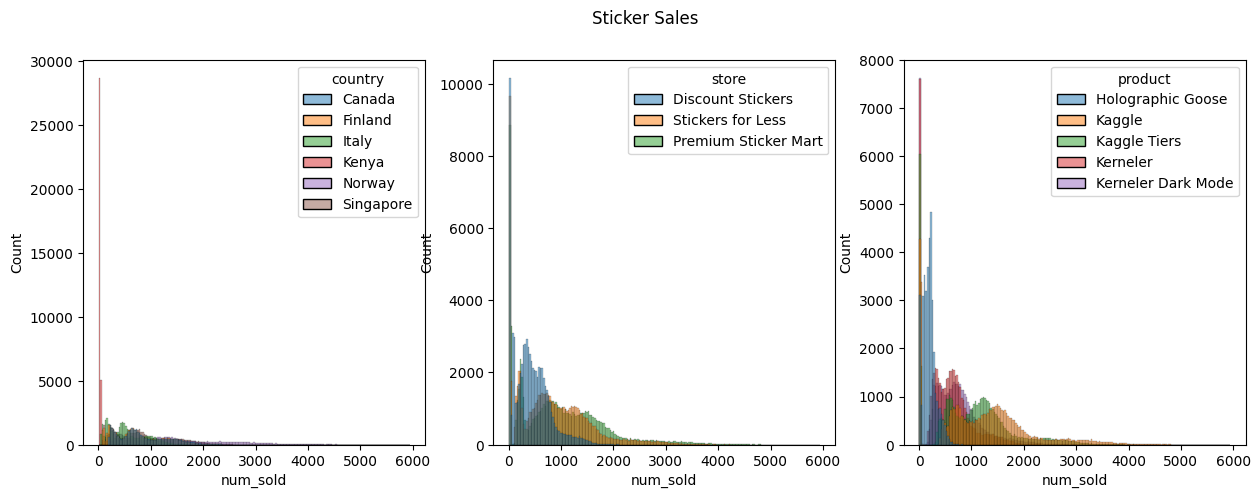

In [11]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))

plt.suptitle("Sticker Sales")

sns.histplot(data=df_train, x='num_sold', hue='country', ax=axes[0]);

sns.histplot(data=df_train, x='num_sold', hue='store', ax=axes[1]);

sns.histplot(data=df_train, x='num_sold', hue='product', ax=axes[2]);

## **1-1- The relationship between Canada and the sale of Holographic Goose stickers**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
I checked the relationship of column "country" and row "Canada" with columns "product" and "num_sold"
    </font>
</div>

In [12]:
print(len(df_train.loc[(df_train['country']=='Canada')&(df_train['num_sold'].isnull())]))
print(len(df_train.loc[(df_train['country']=='Canada')&(df_train['product']=='Holographic Goose')&(df_train['num_sold'].isnull())]))
print(len(df_train.loc[(df_train['country']=='Canada')&(df_train['product']=='Kaggle')&(df_train['num_sold'].isnull())]))
print(len(df_train.loc[(df_train['country']=='Canada')&(df_train['product']=='Kaggle Tiers')&(df_train['num_sold'].isnull())]))
print(len(df_train.loc[(df_train['country']=='Canada')&(df_train['product']=='Kerneler')&(df_train['num_sold'].isnull())]))
print(len(df_train.loc[(df_train['country']=='Canada')&(df_train['product']=='Kerneler Dark Mode')&(df_train['num_sold'].isnull())]))

4246
4245
0
0
1
0


----------------------------------

In [13]:
#Example
print('store: Discount Stickers, product: Kaggle ==>',list(df_train.loc[(df_train['date']=='2010-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Kaggle')]['num_sold'])[0])
print('store: Stickers for Less, product: Kaggle ==>',list(df_train.loc[(df_train['date']=='2010-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Kaggle')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Kaggle ==>',list(df_train.loc[(df_train['date']=='2010-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Kaggle')]['num_sold'])[0])

store: Discount Stickers, product: Kaggle ==> 688.0
store: Stickers for Less, product: Kaggle ==> 1383.0
store: Premium Sticker Mart, product: Kaggle ==> 1787.0


In [14]:
#Example
print('store: Discount Stickers, product: Kaggle ==>',list(df_train.loc[(df_train['date']=='2011-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Kaggle')]['num_sold'])[0])
print('store: Stickers for Less, product: Kaggle ==>',list(df_train.loc[(df_train['date']=='2011-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Kaggle')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Kaggle ==>',list(df_train.loc[(df_train['date']=='2011-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Kaggle')]['num_sold'])[0])

store: Discount Stickers, product: Kaggle ==> 871.0
store: Stickers for Less, product: Kaggle ==> 1540.0
store: Premium Sticker Mart, product: Kaggle ==> 1928.0


In [15]:
#Example
print('store: Discount Stickers, product: Kaggle ==>',list(df_train.loc[(df_train['date']=='2012-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Kaggle')]['num_sold'])[0])
print('store: Stickers for Less, product: Kaggle ==>',list(df_train.loc[(df_train['date']=='2012-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Kaggle')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Kaggle ==>',list(df_train.loc[(df_train['date']=='2012-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Kaggle')]['num_sold'])[0])

store: Discount Stickers, product: Kaggle ==> 658.0
store: Stickers for Less, product: Kaggle ==> 1343.0
store: Premium Sticker Mart, product: Kaggle ==> 1515.0


In [16]:
#Example
print('store: Discount Stickers, product: Kaggle ==>',list(df_train.loc[(df_train['date']=='2013-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Kaggle')]['num_sold'])[0])
print('store: Stickers for Less, product: Kaggle ==>',list(df_train.loc[(df_train['date']=='2013-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Kaggle')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Kaggle ==>',list(df_train.loc[(df_train['date']=='2013-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Kaggle')]['num_sold'])[0])

store: Discount Stickers, product: Kaggle ==> 727.0
store: Stickers for Less, product: Kaggle ==> 1477.0
store: Premium Sticker Mart, product: Kaggle ==> 1621.0


In [17]:
#Example
print('store: Discount Stickers, product: Kaggle ==>',list(df_train.loc[(df_train['date']=='2014-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Kaggle')]['num_sold'])[0])
print('store: Stickers for Less, product: Kaggle ==>',list(df_train.loc[(df_train['date']=='2014-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Kaggle')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Kaggle ==>',list(df_train.loc[(df_train['date']=='2014-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Kaggle')]['num_sold'])[0])

store: Discount Stickers, product: Kaggle ==> 711.0
store: Stickers for Less, product: Kaggle ==> 1516.0
store: Premium Sticker Mart, product: Kaggle ==> 1501.0


In [18]:
#Example
print('store: Discount Stickers, product: Kaggle ==>',list(df_train.loc[(df_train['date']=='2015-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Kaggle')]['num_sold'])[0])
print('store: Stickers for Less, product: Kaggle ==>',list(df_train.loc[(df_train['date']=='2015-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Kaggle')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Kaggle ==>',list(df_train.loc[(df_train['date']=='2015-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Kaggle')]['num_sold'])[0])

store: Discount Stickers, product: Kaggle ==> 636.0
store: Stickers for Less, product: Kaggle ==> 1325.0
store: Premium Sticker Mart, product: Kaggle ==> 1328.0


----------------------------------

In [19]:
#Example
print('store: Discount Stickers, product: Kaggle Tiers ==>',list(df_train.loc[(df_train['date']=='2010-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Kaggle Tiers')]['num_sold'])[0])
print('store: Stickers for Less, product: Kaggle Tiers ==>',list(df_train.loc[(df_train['date']=='2010-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Kaggle Tiers')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Kaggle Tiers ==>',list(df_train.loc[(df_train['date']=='2010-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Kaggle Tiers')]['num_sold'])[0])

store: Discount Stickers, product: Kaggle Tiers ==> 558.0
store: Stickers for Less, product: Kaggle Tiers ==> 1110.0
store: Premium Sticker Mart, product: Kaggle Tiers ==> 1311.0


In [20]:
#Example
print('store: Discount Stickers, product: Kaggle Tiers ==>',list(df_train.loc[(df_train['date']=='2012-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Kaggle Tiers')]['num_sold'])[0])
print('store: Stickers for Less, product: Kaggle Tiers ==>',list(df_train.loc[(df_train['date']=='2012-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Kaggle Tiers')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Kaggle Tiers ==>',list(df_train.loc[(df_train['date']=='2012-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Kaggle Tiers')]['num_sold'])[0])

store: Discount Stickers, product: Kaggle Tiers ==> 587.0
store: Stickers for Less, product: Kaggle Tiers ==> 1178.0
store: Premium Sticker Mart, product: Kaggle Tiers ==> 1490.0


In [21]:
#Example
print('store: Discount Stickers, product: Kaggle Tiers ==>',list(df_train.loc[(df_train['date']=='2015-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Kaggle Tiers')]['num_sold'])[0])
print('store: Stickers for Less, product: Kaggle Tiers ==>',list(df_train.loc[(df_train['date']=='2015-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Kaggle Tiers')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Kaggle Tiers ==>',list(df_train.loc[(df_train['date']=='2015-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Kaggle Tiers')]['num_sold'])[0])

store: Discount Stickers, product: Kaggle Tiers ==> 529.0
store: Stickers for Less, product: Kaggle Tiers ==> 1112.0
store: Premium Sticker Mart, product: Kaggle Tiers ==> 1425.0


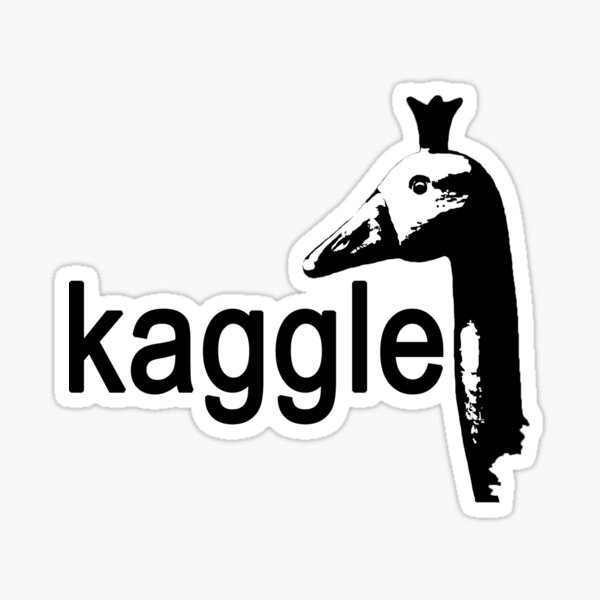

----------------------------------

In [22]:
#Example
print('store: Discount Stickers, product: Kerneler ==>',list(df_train.loc[(df_train['date']=='2010-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Kerneler')]['num_sold'])[0])
print('store: Stickers for Less, product: Kerneler ==>',list(df_train.loc[(df_train['date']=='2010-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Kerneler')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Kerneler ==>',list(df_train.loc[(df_train['date']=='2010-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Kerneler')]['num_sold'])[0])

store: Discount Stickers, product: Kerneler ==> 375.0
store: Stickers for Less, product: Kerneler ==> 642.0
store: Premium Sticker Mart, product: Kerneler ==> 831.0


In [23]:
#Example
print('store: Discount Stickers, product: Kerneler ==>',list(df_train.loc[(df_train['date']=='2012-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Kerneler')]['num_sold'])[0])
print('store: Stickers for Less, product: Kerneler ==>',list(df_train.loc[(df_train['date']=='2012-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Kerneler')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Kerneler ==>',list(df_train.loc[(df_train['date']=='2012-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Kerneler')]['num_sold'])[0])

store: Discount Stickers, product: Kerneler ==> 350.0
store: Stickers for Less, product: Kerneler ==> 762.0
store: Premium Sticker Mart, product: Kerneler ==> 864.0


In [24]:
#Example
print('store: Discount Stickers, product: Kerneler ==>',list(df_train.loc[(df_train['date']=='2015-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Kerneler')]['num_sold'])[0])
print('store: Stickers for Less, product: Kerneler ==>',list(df_train.loc[(df_train['date']=='2015-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Kerneler')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Kerneler ==>',list(df_train.loc[(df_train['date']=='2015-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Kerneler')]['num_sold'])[0])

store: Discount Stickers, product: Kerneler ==> 332.0
store: Stickers for Less, product: Kerneler ==> 673.0
store: Premium Sticker Mart, product: Kerneler ==> 747.0


----------------------------------

In [25]:
#Example
print('store: Discount Stickers, product: Kerneler Dark Mode ==>',list(df_train.loc[(df_train['date']=='2010-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Kerneler Dark Mode')]['num_sold'])[0])
print('store: Stickers for Less, product: Kerneler Dark Mode ==>',list(df_train.loc[(df_train['date']=='2010-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Kerneler Dark Mode')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Kerneler Dark Mode ==>',list(df_train.loc[(df_train['date']=='2010-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Kerneler Dark Mode')]['num_sold'])[0])

store: Discount Stickers, product: Kerneler Dark Mode ==> 284.0
store: Stickers for Less, product: Kerneler Dark Mode ==> 584.0
store: Premium Sticker Mart, product: Kerneler Dark Mode ==> 627.0


In [26]:
#Example
print('store: Discount Stickers, product: Kerneler Dark Mode ==>',list(df_train.loc[(df_train['date']=='2012-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Kerneler Dark Mode')]['num_sold'])[0])
print('store: Stickers for Less, product: Kerneler Dark Mode ==>',list(df_train.loc[(df_train['date']=='2012-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Kerneler Dark Mode')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Kerneler Dark Mode ==>',list(df_train.loc[(df_train['date']=='2012-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Kerneler Dark Mode')]['num_sold'])[0])

store: Discount Stickers, product: Kerneler Dark Mode ==> 279.0
store: Stickers for Less, product: Kerneler Dark Mode ==> 559.0
store: Premium Sticker Mart, product: Kerneler Dark Mode ==> 698.0


In [27]:
#Example
print('store: Discount Stickers, product: Kerneler Dark Mode ==>',list(df_train.loc[(df_train['date']=='2015-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Kerneler Dark Mode')]['num_sold'])[0])
print('store: Stickers for Less, product: Kerneler Dark Mode ==>',list(df_train.loc[(df_train['date']=='2015-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Kerneler Dark Mode')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Kerneler Dark Mode ==>',list(df_train.loc[(df_train['date']=='2015-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Kerneler Dark Mode')]['num_sold'])[0])

store: Discount Stickers, product: Kerneler Dark Mode ==> 252.0
store: Stickers for Less, product: Kerneler Dark Mode ==> 547.0
store: Premium Sticker Mart, product: Kerneler Dark Mode ==> 622.0


----------------------------------

In [28]:
print('store: Discount Stickers, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2010-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Stickers for Less, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2010-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2010-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])

store: Discount Stickers, product: Holographic Goose ==> nan
store: Stickers for Less, product: Holographic Goose ==> nan
store: Premium Sticker Mart, product: Holographic Goose ==> 236.0


In [29]:
print('store: Discount Stickers, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2010-02-01')&(df_train['country']=='Canada')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Stickers for Less, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2010-02-01')&(df_train['country']=='Canada')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2010-02-01')&(df_train['country']=='Canada')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])

store: Discount Stickers, product: Holographic Goose ==> nan
store: Stickers for Less, product: Holographic Goose ==> nan
store: Premium Sticker Mart, product: Holographic Goose ==> 218.0


In [30]:
print('store: Discount Stickers, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2011-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Stickers for Less, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2011-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2011-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])

store: Discount Stickers, product: Holographic Goose ==> nan
store: Stickers for Less, product: Holographic Goose ==> 214.0
store: Premium Sticker Mart, product: Holographic Goose ==> 265.0


In [31]:
print('store: Discount Stickers, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2011-02-01')&(df_train['country']=='Canada')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Stickers for Less, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2011-02-01')&(df_train['country']=='Canada')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2011-02-01')&(df_train['country']=='Canada')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])

store: Discount Stickers, product: Holographic Goose ==> nan
store: Stickers for Less, product: Holographic Goose ==> 248.0
store: Premium Sticker Mart, product: Holographic Goose ==> 285.0


In [32]:
print('store: Discount Stickers, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2012-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Stickers for Less, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2012-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2012-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])

store: Discount Stickers, product: Holographic Goose ==> nan
store: Stickers for Less, product: Holographic Goose ==> nan
store: Premium Sticker Mart, product: Holographic Goose ==> 251.0


In [33]:
print('store: Discount Stickers, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2012-02-01')&(df_train['country']=='Canada')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Stickers for Less, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2012-02-01')&(df_train['country']=='Canada')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2012-02-01')&(df_train['country']=='Canada')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])

store: Discount Stickers, product: Holographic Goose ==> nan
store: Stickers for Less, product: Holographic Goose ==> 231.0
store: Premium Sticker Mart, product: Holographic Goose ==> 270.0


In [34]:
print('store: Discount Stickers, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2013-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Stickers for Less, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2013-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2013-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])

store: Discount Stickers, product: Holographic Goose ==> nan
store: Stickers for Less, product: Holographic Goose ==> 201.0
store: Premium Sticker Mart, product: Holographic Goose ==> 229.0


In [35]:
print('store: Discount Stickers, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2013-02-01')&(df_train['country']=='Canada')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Stickers for Less, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2013-02-01')&(df_train['country']=='Canada')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2013-02-01')&(df_train['country']=='Canada')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])

store: Discount Stickers, product: Holographic Goose ==> nan
store: Stickers for Less, product: Holographic Goose ==> 218.0
store: Premium Sticker Mart, product: Holographic Goose ==> 256.0


In [36]:
print('store: Discount Stickers, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2014-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Stickers for Less, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2014-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2014-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])

store: Discount Stickers, product: Holographic Goose ==> nan
store: Stickers for Less, product: Holographic Goose ==> nan
store: Premium Sticker Mart, product: Holographic Goose ==> 231.0


In [37]:
print('store: Discount Stickers, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2014-02-01')&(df_train['country']=='Canada')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Stickers for Less, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2014-02-01')&(df_train['country']=='Canada')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2014-02-01')&(df_train['country']=='Canada')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])

store: Discount Stickers, product: Holographic Goose ==> nan
store: Stickers for Less, product: Holographic Goose ==> 259.0
store: Premium Sticker Mart, product: Holographic Goose ==> 289.0


In [38]:
print('store: Discount Stickers, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2015-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Stickers for Less, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2015-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2015-10-01')&(df_train['country']=='Canada')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])

store: Discount Stickers, product: Holographic Goose ==> nan
store: Stickers for Less, product: Holographic Goose ==> nan
store: Premium Sticker Mart, product: Holographic Goose ==> nan


In [39]:
print('store: Discount Stickers, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2015-02-01')&(df_train['country']=='Canada')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Stickers for Less, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2015-02-01')&(df_train['country']=='Canada')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2015-02-01')&(df_train['country']=='Canada')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])

store: Discount Stickers, product: Holographic Goose ==> nan
store: Stickers for Less, product: Holographic Goose ==> 230.0
store: Premium Sticker Mart, product: Holographic Goose ==> 288.0


----------------------------------

In [40]:
x = list(df_train.loc[(df_train['country']=='Canada')&(df_train['product']=='Holographic Goose')&(df_train['num_sold'].notnull())]['num_sold'].mode())[0]
x

218.0

In [41]:
x = list(df_train.loc[(df_train['country']=='Canada')&(df_train['product']=='Holographic Goose')&(df_train['num_sold'].notnull())]['num_sold'].mode())[0]
ind = df_train.loc[(df_train['country']=='Canada')&(df_train['product']=='Holographic Goose')&(df_train['num_sold'].isnull())].index

for i in ind:
    df_train.loc[i, 'num_sold'] = x

In [42]:
print(len(df_train.loc[(df_train['country']=='Canada')&(df_train['num_sold'].isnull())]))
print(len(df_train.loc[(df_train['country']=='Canada')&(df_train['product']=='Holographic Goose')&(df_train['num_sold'].isnull())]))
print(len(df_train.loc[(df_train['country']=='Canada')&(df_train['product']=='Kaggle')&(df_train['num_sold'].isnull())]))
print(len(df_train.loc[(df_train['country']=='Canada')&(df_train['product']=='Kaggle Tiers')&(df_train['num_sold'].isnull())]))
print(len(df_train.loc[(df_train['country']=='Canada')&(df_train['product']=='Kerneler')&(df_train['num_sold'].isnull())]))
print(len(df_train.loc[(df_train['country']=='Canada')&(df_train['product']=='Kerneler Dark Mode')&(df_train['num_sold'].isnull())]))

1
0
0
0
1
0


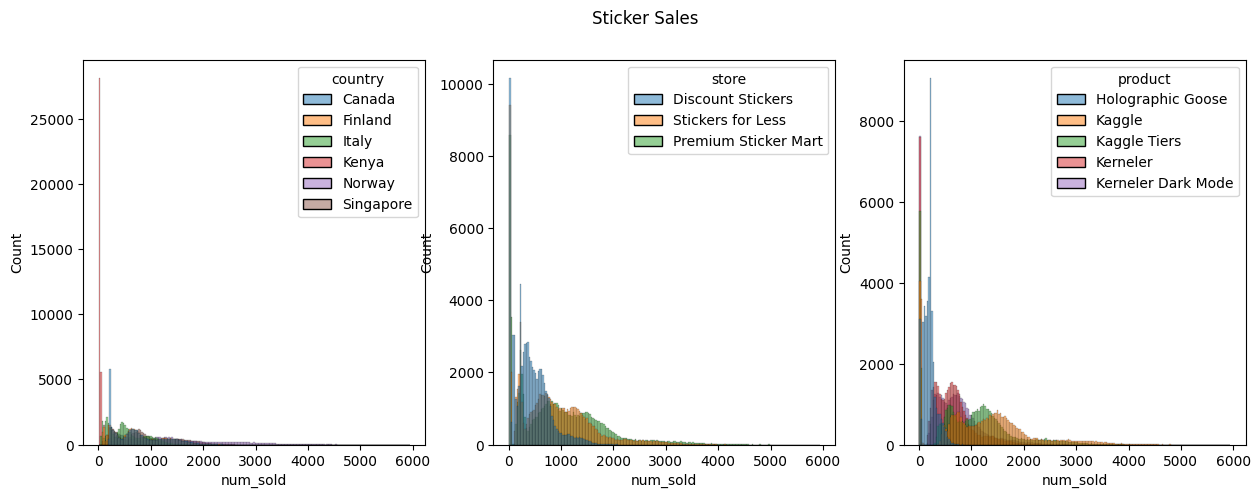

In [43]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))

plt.suptitle("Sticker Sales")

sns.histplot(data=df_train, x='num_sold', hue='country', ax=axes[0]);

sns.histplot(data=df_train, x='num_sold', hue='store', ax=axes[1]);

sns.histplot(data=df_train, x='num_sold', hue='product', ax=axes[2]);

-----------------------------------------------

In [44]:
missing_values_count = df_train.isnull().sum()
missing_values_count

id             0
date           0
country        0
store          0
product        0
num_sold    4626
dtype: int64

In [45]:
df_train.loc[df_train['num_sold'].isnull()]

,id,date,country,store,product,num_sold
45,45,2010-01-01,Kenya,Discount Stickers,Holographic Goose,NaN
135,135,2010-01-02,Kenya,Discount Stickers,Holographic Goose,NaN
225,225,2010-01-03,Kenya,Discount Stickers,Holographic Goose,NaN
315,315,2010-01-04,Kenya,Discount Stickers,Holographic Goose,NaN
320,320,2010-01-04,Kenya,Stickers for Less,Holographic Goose,NaN
...,...,...,...,...,...,...
229725,229725,2016-12-27,Kenya,Discount Stickers,Holographic Goose,NaN
229815,229815,2016-12-28,Kenya,Discount Stickers,Holographic Goose,NaN
229905,229905,2016-12-29,Kenya,Discount Stickers,Holographic Goose,NaN
229995,229995,2016-12-30,Kenya,Discount Stickers,Holographic Goose,NaN


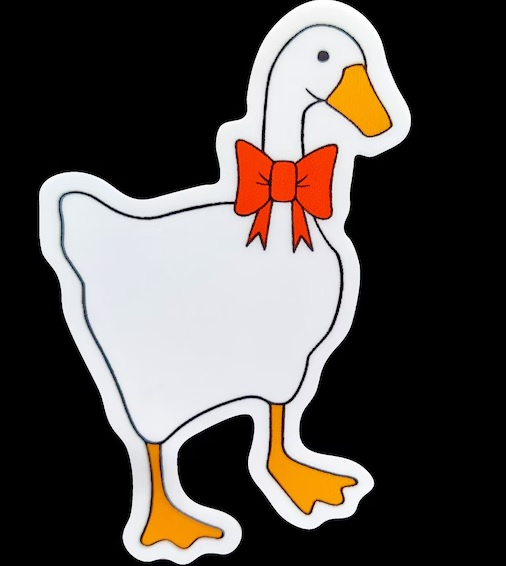

## **1-2- The relationship between Kenya and the sale of Holographic Goose stickers**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
I checked the relationship of column "country" and row "Kenya" with columns "product" and "num_sold"
    </font>
</div>

In [46]:
print(len(df_train.loc[(df_train['country']=='Kenya')&(df_train['num_sold'].isnull())]))
print(len(df_train.loc[(df_train['country']=='Kenya')&(df_train['product']=='Holographic Goose')&(df_train['num_sold'].isnull())]))
print(len(df_train.loc[(df_train['country']=='Kenya')&(df_train['product']=='Kaggle')&(df_train['num_sold'].isnull())]))
print(len(df_train.loc[(df_train['country']=='Kenya')&(df_train['product']=='Kaggle Tiers')&(df_train['num_sold'].isnull())]))
print(len(df_train.loc[(df_train['country']=='Kenya')&(df_train['product']=='Kerneler')&(df_train['num_sold'].isnull())]))
print(len(df_train.loc[(df_train['country']=='Kenya')&(df_train['product']=='Kerneler Dark Mode')&(df_train['num_sold'].isnull())]))

4625
4561
0
0
63
1


In [47]:
print('store: Discount Stickers, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2010-10-01')&(df_train['country']=='Kenya')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Stickers for Less, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2010-10-01')&(df_train['country']=='Kenya')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2010-10-01')&(df_train['country']=='Kenya')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])

store: Discount Stickers, product: Holographic Goose ==> nan
store: Stickers for Less, product: Holographic Goose ==> nan
store: Premium Sticker Mart, product: Holographic Goose ==> nan


In [48]:
print('store: Discount Stickers, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2011-10-01')&(df_train['country']=='Kenya')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Stickers for Less, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2011-10-01')&(df_train['country']=='Kenya')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2011-10-01')&(df_train['country']=='Kenya')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])

store: Discount Stickers, product: Holographic Goose ==> nan
store: Stickers for Less, product: Holographic Goose ==> nan
store: Premium Sticker Mart, product: Holographic Goose ==> nan


In [49]:
print('store: Discount Stickers, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2011-12-01')&(df_train['country']=='Kenya')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Stickers for Less, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2011-12-01')&(df_train['country']=='Kenya')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2011-12-01')&(df_train['country']=='Kenya')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])

store: Discount Stickers, product: Holographic Goose ==> nan
store: Stickers for Less, product: Holographic Goose ==> nan
store: Premium Sticker Mart, product: Holographic Goose ==> 5.0


In [50]:
print('store: Discount Stickers, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2013-10-01')&(df_train['country']=='Kenya')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Stickers for Less, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2013-10-01')&(df_train['country']=='Kenya')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2013-10-01')&(df_train['country']=='Kenya')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])

store: Discount Stickers, product: Holographic Goose ==> nan
store: Stickers for Less, product: Holographic Goose ==> nan
store: Premium Sticker Mart, product: Holographic Goose ==> 5.0


In [51]:
print('store: Discount Stickers, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2014-10-01')&(df_train['country']=='Kenya')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Stickers for Less, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2014-10-01')&(df_train['country']=='Kenya')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2014-10-01')&(df_train['country']=='Kenya')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])

store: Discount Stickers, product: Holographic Goose ==> nan
store: Stickers for Less, product: Holographic Goose ==> nan
store: Premium Sticker Mart, product: Holographic Goose ==> 5.0


In [52]:
print('store: Discount Stickers, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2015-10-01')&(df_train['country']=='Kenya')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Stickers for Less, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2015-10-01')&(df_train['country']=='Kenya')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2015-10-01')&(df_train['country']=='Kenya')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Holographic Goose')]['num_sold'])[0])

store: Discount Stickers, product: Holographic Goose ==> nan
store: Stickers for Less, product: Holographic Goose ==> 5.0
store: Premium Sticker Mart, product: Holographic Goose ==> 5.0


In [53]:
x = list(df_train.loc[(df_train['country']=='Kenya')&(df_train['product']=='Holographic Goose')&(df_train['num_sold'].notnull())]['num_sold'].mode())[0]
print(x)
ind = df_train.loc[(df_train['country']=='Kenya')&(df_train['product']=='Holographic Goose')&(df_train['num_sold'].isnull())].index

for i in ind:
    df_train.loc[i, 'num_sold'] = x

5.0


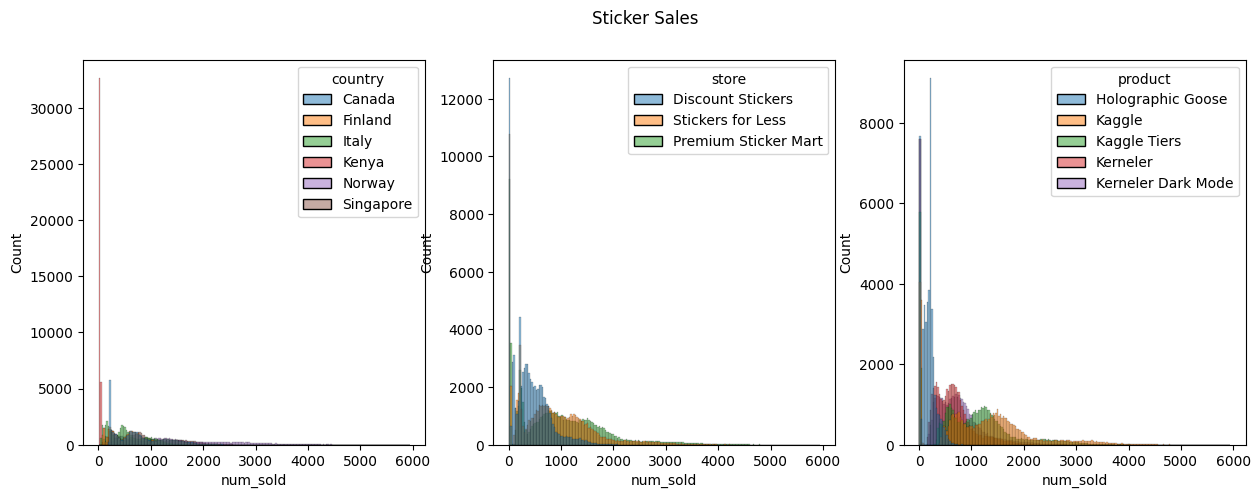

In [54]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))

plt.suptitle("Sticker Sales")

sns.histplot(data=df_train, x='num_sold', hue='country', ax=axes[0]);

sns.histplot(data=df_train, x='num_sold', hue='store', ax=axes[1]);

sns.histplot(data=df_train, x='num_sold', hue='product', ax=axes[2]);

---------------------------------------

In [55]:
missing_values_count = df_train.isnull().sum()
missing_values_count

id           0
date         0
country      0
store        0
product      0
num_sold    65
dtype: int64

In [56]:
df_train.loc[df_train['num_sold'].isnull()]

,id,date,country,store,product,num_sold
1128,1128,2010-01-13,Kenya,Discount Stickers,Kerneler,NaN
3108,3108,2010-02-04,Kenya,Discount Stickers,Kerneler,NaN
3558,3558,2010-02-09,Kenya,Discount Stickers,Kerneler,NaN
3738,3738,2010-02-11,Kenya,Discount Stickers,Kerneler,NaN
4098,4098,2010-02-15,Kenya,Discount Stickers,Kerneler,NaN
...,...,...,...,...,...,...
41988,41988,2011-04-12,Kenya,Discount Stickers,Kerneler,NaN
42078,42078,2011-04-13,Kenya,Discount Stickers,Kerneler,NaN
42708,42708,2011-04-20,Kenya,Discount Stickers,Kerneler,NaN
45048,45048,2011-05-16,Kenya,Discount Stickers,Kerneler,NaN


In [57]:
print('store: Discount Stickers, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2010-10-01')&(df_train['country']=='Kenya')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Kerneler')]['num_sold'])[0])
print('store: Stickers for Less, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2010-10-01')&(df_train['country']=='Kenya')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Kerneler')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2010-10-01')&(df_train['country']=='Kenya')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Kerneler')]['num_sold'])[0])

store: Discount Stickers, product: Holographic Goose ==> 6.0
store: Stickers for Less, product: Holographic Goose ==> 14.0
store: Premium Sticker Mart, product: Holographic Goose ==> 16.0


In [58]:
print('store: Discount Stickers, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2011-10-01')&(df_train['country']=='Kenya')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Kerneler')]['num_sold'])[0])
print('store: Stickers for Less, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2011-10-01')&(df_train['country']=='Kenya')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Kerneler')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2011-10-01')&(df_train['country']=='Kenya')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Kerneler')]['num_sold'])[0])

store: Discount Stickers, product: Holographic Goose ==> 8.0
store: Stickers for Less, product: Holographic Goose ==> 15.0
store: Premium Sticker Mart, product: Holographic Goose ==> 18.0


In [59]:
print('store: Discount Stickers, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2012-10-01')&(df_train['country']=='Kenya')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Kerneler')]['num_sold'])[0])
print('store: Stickers for Less, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2012-10-01')&(df_train['country']=='Kenya')&(df_train['store']=='Stickers for Less')&(df_train['product']=='Kerneler')]['num_sold'])[0])
print('store: Premium Sticker Mart, product: Holographic Goose ==>',list(df_train.loc[(df_train['date']=='2012-10-01')&(df_train['country']=='Kenya')&(df_train['store']=='Premium Sticker Mart')&(df_train['product']=='Kerneler')]['num_sold'])[0])

store: Discount Stickers, product: Holographic Goose ==> 7.0
store: Stickers for Less, product: Holographic Goose ==> 15.0
store: Premium Sticker Mart, product: Holographic Goose ==> 19.0


In [60]:
df_train.loc[(df_train['country']=='Kenya')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Kerneler')]['num_sold']

48         8.0
138        8.0
228        8.0
318        6.0
408        6.0
          ... 
229728    10.0
229818    10.0
229908    11.0
229998    13.0
230088    14.0
Name: num_sold, Length: 2557, dtype: float64

In [61]:
len(df_train.loc[(df_train['country']=='Kenya')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Kerneler')&(df_train['num_sold'].isnull())])

63

In [62]:
x = list(df_train.loc[(df_train['country']=='Kenya')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Kerneler')&(df_train['num_sold'].notnull())]['num_sold'].mode())[0]
print(x)
ind = df_train.loc[(df_train['country']=='Kenya')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Kerneler')&(df_train['num_sold'].isnull())].index

for i in ind:
    df_train.loc[i, 'num_sold'] = x

7.0


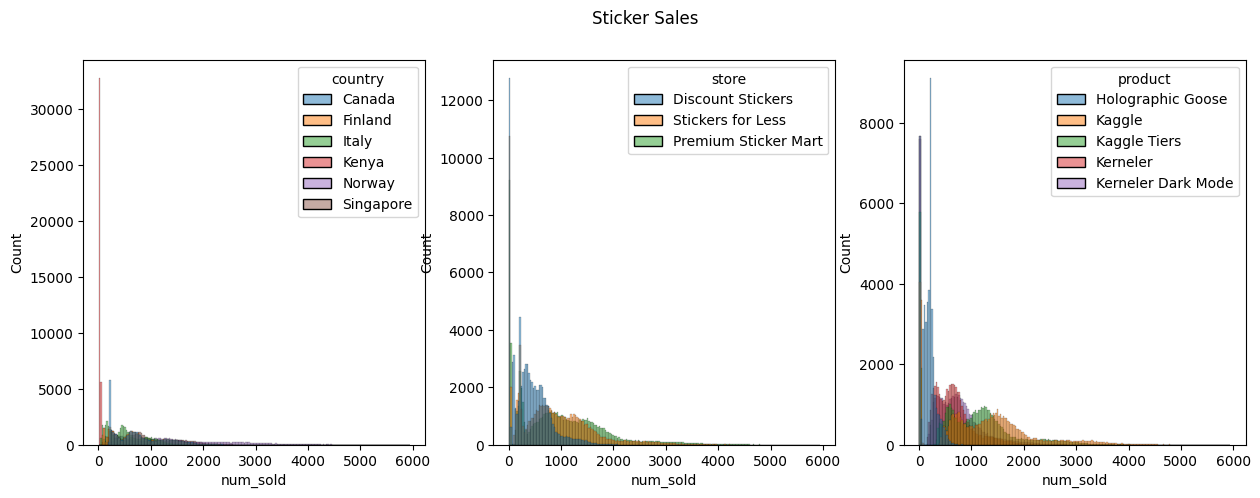

In [63]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))

plt.suptitle("Sticker Sales")

sns.histplot(data=df_train, x='num_sold', hue='country', ax=axes[0]);

sns.histplot(data=df_train, x='num_sold', hue='store', ax=axes[1]);

sns.histplot(data=df_train, x='num_sold', hue='product', ax=axes[2]);

----------------------------------------------------

In [64]:
missing_values_count = df_train.isnull().sum()
missing_values_count

id          0
date        0
country     0
store       0
product     0
num_sold    2
dtype: int64

In [65]:
df_train.loc[df_train['num_sold'].isnull()]

,id,date,country,store,product,num_sold
23719,23719,2010-09-21,Kenya,Discount Stickers,Kerneler Dark Mode,NaN
207003,207003,2016-04-19,Canada,Discount Stickers,Kerneler,NaN


In [66]:
x = list(df_train.loc[(df_train['country']=='Kenya')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Kerneler Dark Mode')&(df_train['num_sold'].notnull())]['num_sold'].mode())[0]
print(x)
ind = df_train.loc[(df_train['country']=='Kenya')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Kerneler Dark Mode')&(df_train['num_sold'].isnull())].index
df_train.loc[ind, 'num_sold'] = x

8.0


In [67]:
x = list(df_train.loc[(df_train['country']=='Canada')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Kerneler')&(df_train['num_sold'].notnull())]['num_sold'].mode())[0]
print(x)
ind = df_train.loc[(df_train['country']=='Canada')&(df_train['store']=='Discount Stickers')&(df_train['product']=='Kerneler')&(df_train['num_sold'].isnull())].index
df_train.loc[ind, 'num_sold'] = x

285.0


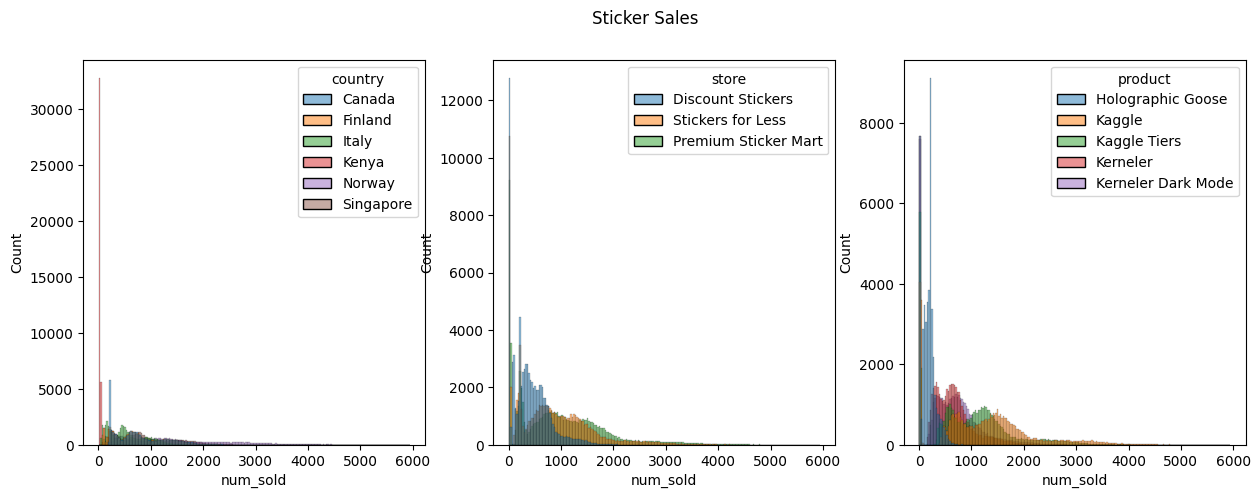

In [68]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))

plt.suptitle("Sticker Sales")

sns.histplot(data=df_train, x='num_sold', hue='country', ax=axes[0]);

sns.histplot(data=df_train, x='num_sold', hue='store', ax=axes[1]);

sns.histplot(data=df_train, x='num_sold', hue='product', ax=axes[2]);

In [69]:
missing_values_count = df_train.isnull().sum()
missing_values_count

id          0
date        0
country     0
store       0
product     0
num_sold    0
dtype: int64

In [70]:
df_train.head(10)

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,218.0
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
5,5,2010-01-01,Canada,Stickers for Less,Holographic Goose,300.0
6,6,2010-01-01,Canada,Stickers for Less,Kaggle,1837.0
7,7,2010-01-01,Canada,Stickers for Less,Kaggle Tiers,1659.0
8,8,2010-01-01,Canada,Stickers for Less,Kerneler,807.0
9,9,2010-01-01,Canada,Stickers for Less,Kerneler Dark Mode,940.0


In [71]:
df_test.head()

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode


In [72]:
missing_values_count = df_test.isnull().sum()
missing_values_count

id         0
date       0
country    0
store      0
product    0
dtype: int64

-----------------------------------------

# **2- Data Preparation**

In [73]:
df_train.head(2)

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,218.0
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0


In [74]:
encoder=LabelEncoder()
df_train['country']=encoder.fit_transform(df_train['country'])
df_train['store']=encoder.fit_transform(df_train['store'])
df_train['product']=encoder.fit_transform(df_train['product'])

In [75]:
X = df_train.drop(['num_sold','date','id'], axis=1)
y = df_train['num_sold']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("The size of the input train data is: {}".format(X_train.shape))
print("The size of the output train data is: {}".format(y_train.shape))
print("The size of the input test data is: {}".format(X_test.shape))
print("The size of the output test data is: {}".format(y_test.shape))

The size of the input train data is: (184104, 3)
The size of the output train data is: (184104,)
The size of the input test data is: (46026, 3)
The size of the output test data is: (46026,)


In [76]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_new = scaler.transform(X_train)
X_test_new = scaler.transform(X_test)

In [77]:
train_sample_size = X_train_new.shape[0]
train_time_steps  = X_train_new.shape[1] 

test_sample_size = X_test_new.shape[0]
test_time_steps  = X_test_new.shape[1]
input_dimension = 1               

train_data_reshaped = X_train_new.reshape(train_sample_size,train_time_steps,input_dimension)
test_data_reshaped = X_test_new.reshape(test_sample_size,test_time_steps,input_dimension)

print("After reshape train data set shape:\n", train_data_reshaped.shape)
print("1 Sample shape:\n",train_data_reshaped[0].shape)

print("After reshape test data set shape:\n", test_data_reshaped.shape)
print("1 Sample shape:\n",test_data_reshaped[0].shape)

After reshape train data set shape:
 (184104, 3, 1)
1 Sample shape:
 (3, 1)
After reshape test data set shape:
 (46026, 3, 1)
1 Sample shape:
 (3, 1)


In [78]:
n_timesteps = train_data_reshaped.shape[1]
n_features  = train_data_reshaped.shape[2]

# **3- Define Model (GRU and LSTM)**

In [79]:
model = Sequential()
model.add(GRU(50,return_sequences=True,input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.2))

model.add(GRU(50,return_sequences=True,input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.4))

model.add(LSTM(50,input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [80]:
callbacks = [
        EarlyStopping(monitor='val_loss', patience=5),
    ]

In [81]:
history = model.fit(train_data_reshaped, y_train, epochs=50, validation_data =(test_data_reshaped, y_test), callbacks=callbacks, verbose=1)

Epoch 1/50
5754/5754 ━━━━━━━━━━━━━━━━━━━━ 52s 8ms/step - loss: 897247.6875 - mae: 669.8699 - val_loss: 682059.4375 - val_mae: 568.2781
Epoch 2/50
5754/5754 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - loss: 635471.5000 - mae: 552.2969 - val_loss: 526008.5000 - val_mae: 518.3630
Epoch 3/50
5754/5754 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - loss: 517780.3750 - mae: 520.6440 - val_loss: 480442.7188 - val_mae: 518.9512
Epoch 4/50
5754/5754 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - loss: 487535.7500 - mae: 527.3676 - val_loss: 475307.8125 - val_mae: 525.5776
Epoch 5/50
5754/5754 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - loss: 483993.3438 - mae: 530.2665 - val_loss: 387789.8750 - val_mae: 414.7999
Epoch 6/50
5754/5754 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - loss: 379041.0000 - mae: 406.8362 - val_loss: 260946.2188 - val_mae: 287.9412
Epoch 7/50
5754/5754 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - loss: 241706.4688 - mae: 281.0775 - val_loss: 173907.9531 - val_mae: 199.9010
Epoch 8/50
5754/5754 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step 

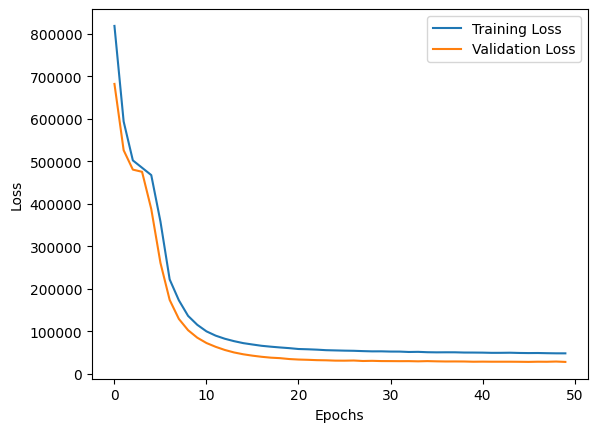

In [82]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

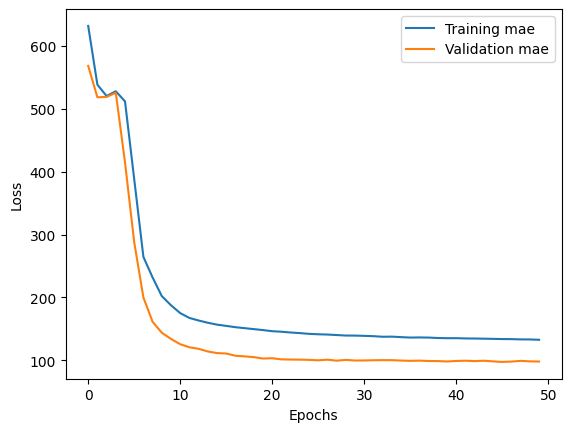

In [83]:
plt.plot(history.history['mae'], label='Training mae')
plt.plot(history.history['val_mae'], label='Validation mae')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [84]:
y_predict = model.predict(X_test)
y_predict = pd.DataFrame(y_predict, columns = ['Predicted_num_sold'])
results = pd.concat([y_predict, y_test.to_frame().reset_index(drop = True)], axis = 1, ignore_index = False)
results.head()
print(results.head(),'\n')

[loss, mae] = model.evaluate(test_data_reshaped, y_test, verbose=0)
print("Testing set MAE: ", mae)

1439/1439 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
   Predicted_num_sold  num_sold
0          409.728088     647.0
1          749.111206    1109.0
2          184.672256     218.0
3          796.929810     423.0
4          213.387482     253.0 

Testing set MAE:  98.04722595214844


# **4- Results**

In [85]:
df_test=pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv')
df_test.head(10)

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode
5,230135,2017-01-01,Canada,Stickers for Less,Holographic Goose
6,230136,2017-01-01,Canada,Stickers for Less,Kaggle
7,230137,2017-01-01,Canada,Stickers for Less,Kaggle Tiers
8,230138,2017-01-01,Canada,Stickers for Less,Kerneler
9,230139,2017-01-01,Canada,Stickers for Less,Kerneler Dark Mode


In [86]:
encoder=LabelEncoder()
df_test['country']=encoder.fit_transform(df_test['country'])
df_test['store']=encoder.fit_transform(df_test['store'])
df_test['product']=encoder.fit_transform(df_test['product'])

In [87]:
X=df_test.drop(columns=['id', 'date'])
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

In [88]:
y_pred = model.predict(X)

3080/3080 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step


In [89]:
df_target = pd.read_csv('/kaggle/input/playground-series-s5e1/sample_submission.csv')
df_target.head()

,id,num_sold
0,230130,100
1,230131,100
2,230132,100
3,230133,100
4,230134,100


In [90]:
test_preds_final = y_pred.copy()
submission_file = df_test.reset_index()[['id']]
submission_file['Predicted num_sold'] = test_preds_final
submission_file = submission_file.set_index("id")
submission_file.head()

,Predicted num_sold
id,
230130,207.363495
230131,672.766113
230132,578.445435
230133,322.447998
230134,355.927307


In [91]:
submission_file.to_csv("/kaggle/working/submission.csv")

<div style="background-color: gray; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
If my notebook was useful for you, please give me a upvote. Thank you for your support ❤️
    <hr style="color: green;"></font>
    <font size="6px">
        <a href="https://omidsakaki.ir/">Website</a>
        <br/>
         <a href="https://github.com/omid-sakaki-ghazvini">Github</a>
        <br/>
        <a href="http://linkedin.com/in/omid-sakaki-ghazvini-378687217">linkedin</a> 
    </font>
</div>